In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

import statsmodels
import statsmodels.api as sm 
import sklearn
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score , mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import warnings
warnings.filterwarnings('ignore')

In [2]:
house_price = pd.read_csv("train.csv")

In [3]:
house_price.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house_price.shape

(1460, 81)

In [5]:
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Cleaning up of data
- Dropping column Id(not usefull in analysis), PoolQC and PoolArea have only 7 values, which are not contributing much.




- For column 'GarageType' there are 81 values with 'No Garage', similarly GarageYrBlt also has 81 NaN values but filling these with 0 doesn't make sense, so instead of dropping the entire column filling with 'yearbuilt' as 75% of rows has 'yearbuilt' and Garageblt as same value. 

- Column 'LotFrontage' has 259 Nan values, since its distance in feet from a lot, we can fill it with 0 instead of deleting the entire column.
- 8 rows from 'MasVnrArea' and 'MasVnrType' are having NaN values, so filling 0 in 'MasVnrArea' instead of dropping the column or the 8 rows as we already have less data


In [6]:
house_price.drop(['Id','PoolQC','PoolArea'],axis = 1, inplace = True)
house_price.loc[house_price['GarageYrBlt'].isna(),'GarageYrBlt'] = house_price['YearBuilt']
house_price['LotFrontage']=house_price['LotFrontage'].fillna(0)
house_price['MasVnrArea']=house_price['MasVnrArea'].fillna(0)

In [7]:
col_type = ['object']
df = house_price.select_dtypes(include=col_type)

dummy_cols_with_NA = []
dummy_cols_without_NA = []

for i in df.columns:
    if df[i].isna().sum()  != 0:
        dummy_cols_with_NA.append(i)
    else:
        dummy_cols_without_NA.append(i)
    

In [8]:
df_with_NA = pd.get_dummies(house_price[dummy_cols_with_NA])
df_without_NA = pd.get_dummies(house_price[dummy_cols_without_NA], drop_first = True)

In [9]:
df_with_NA.shape

(1460, 67)

In [10]:
# There is no Cinderblock item for coulmn 'MasVnrType' in our dataset and item MasVnrType_None can be dropped
df_with_NA.drop(['MasVnrType_None'], axis = 1, inplace = True)

In [11]:
df_without_NA.columns

Index(['MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'Street_Pave', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg',
       'LandContour_HLS', 'LandContour_Low',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=155)

#### Dropping the original categorical columns as we have got their dummies.

In [12]:

house_price.drop(dummy_cols_with_NA+dummy_cols_without_NA, axis = 1, inplace =True)

In [13]:
house_price

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,460,0,40,0,0,0,0,8,2007,175000
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,500,349,0,0,0,0,0,2,2010,210000
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,252,0,60,0,0,0,2500,5,2010,266500
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,240,366,0,112,0,0,0,4,2010,142125


### Visualising the data

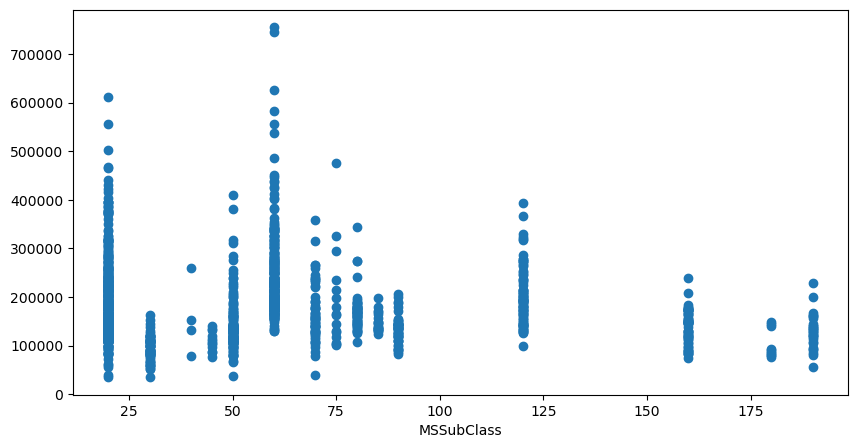

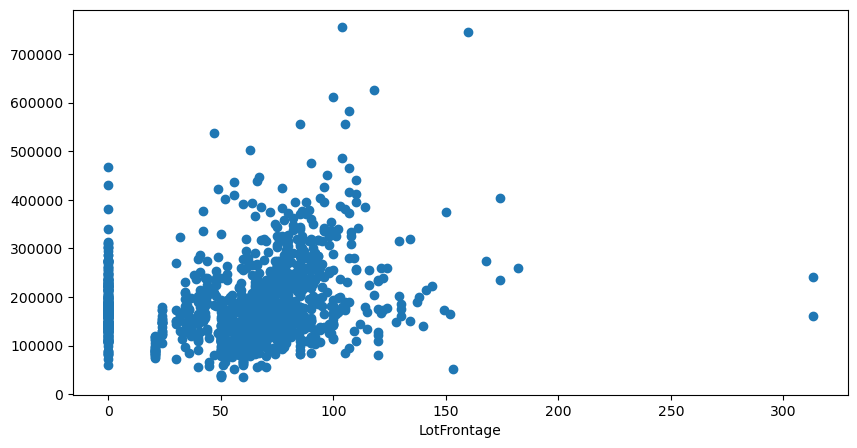

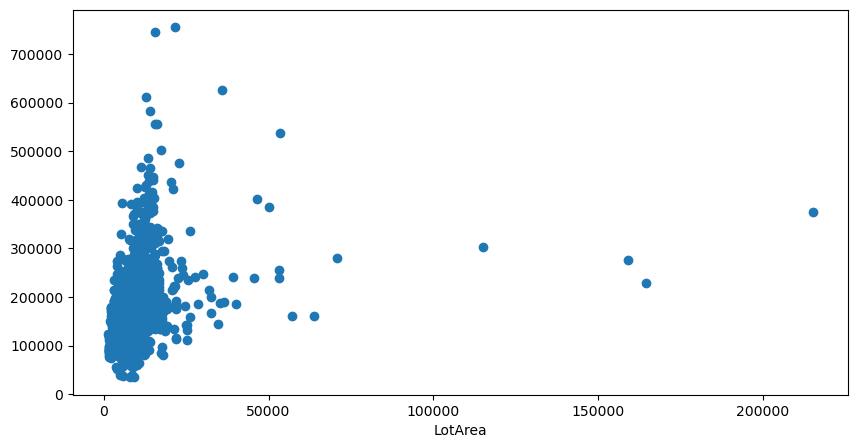

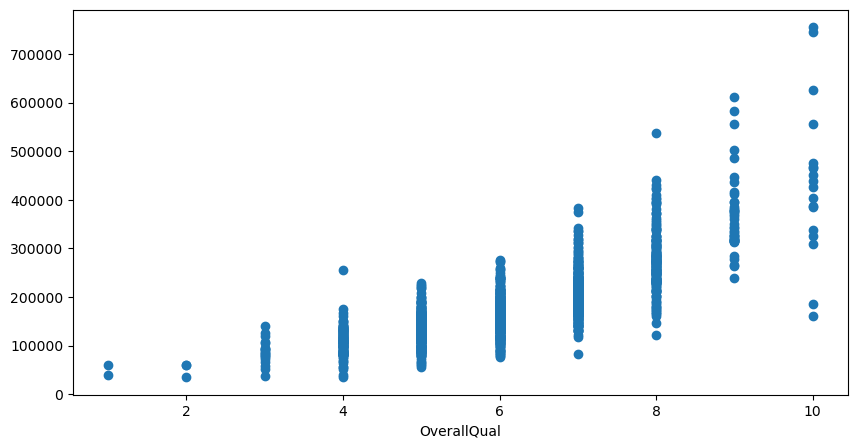

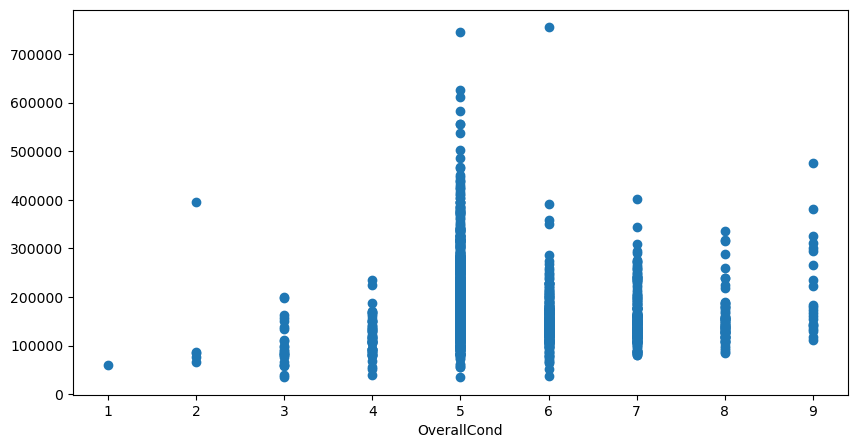

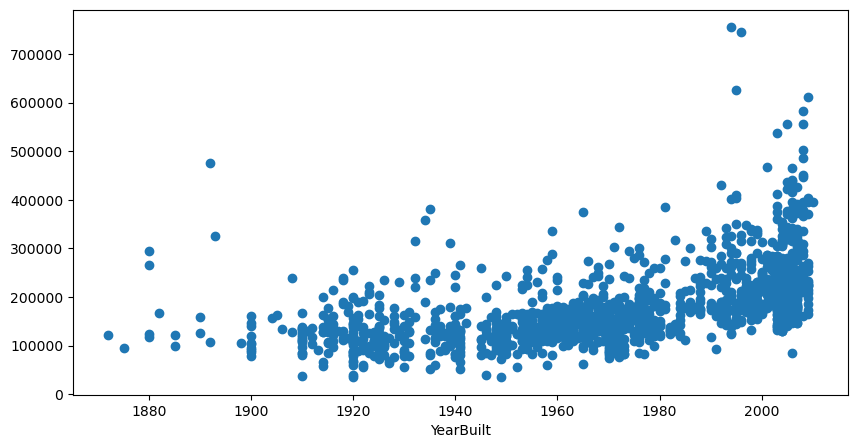

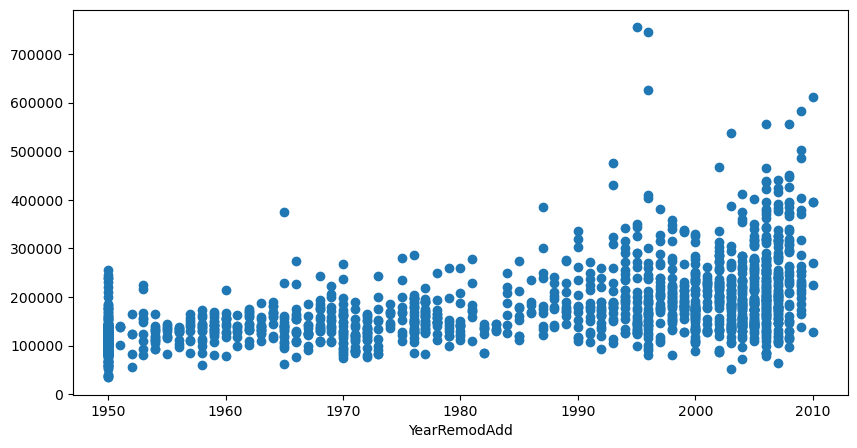

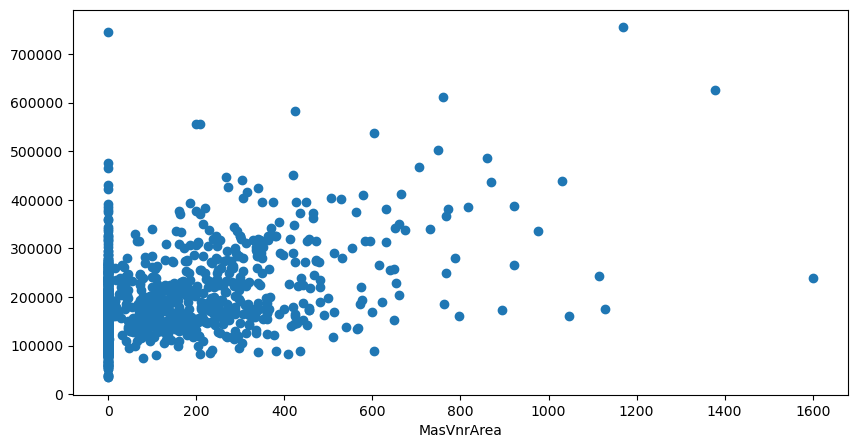

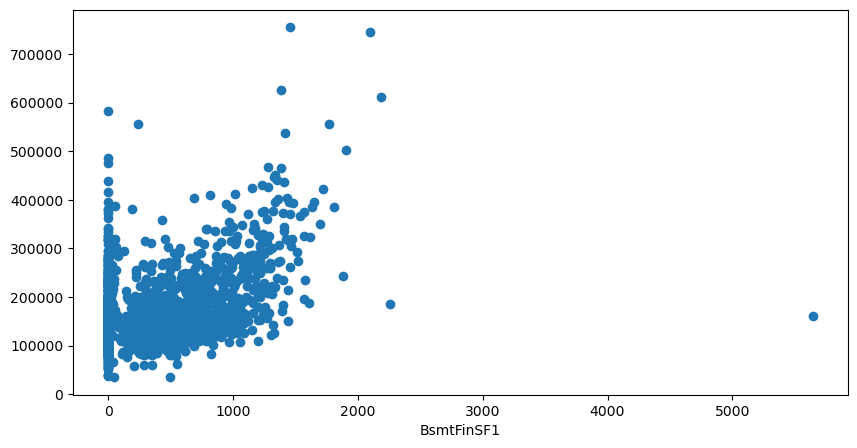

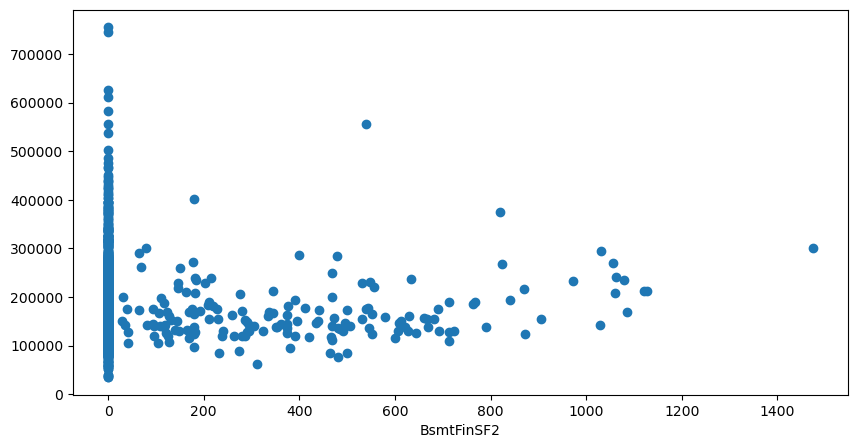

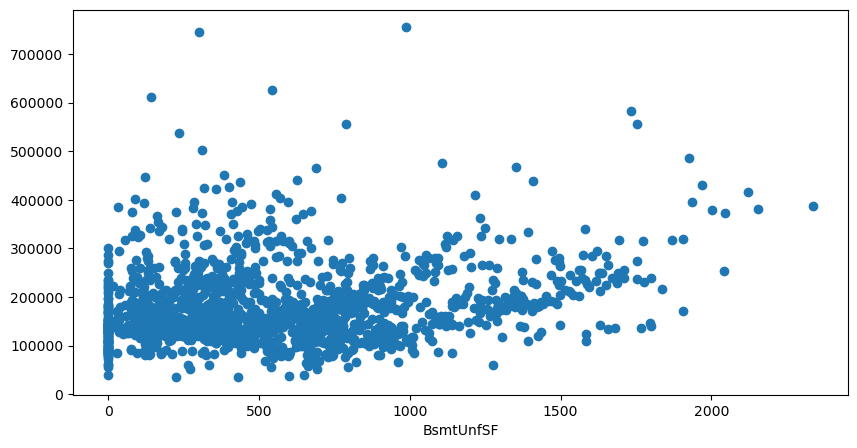

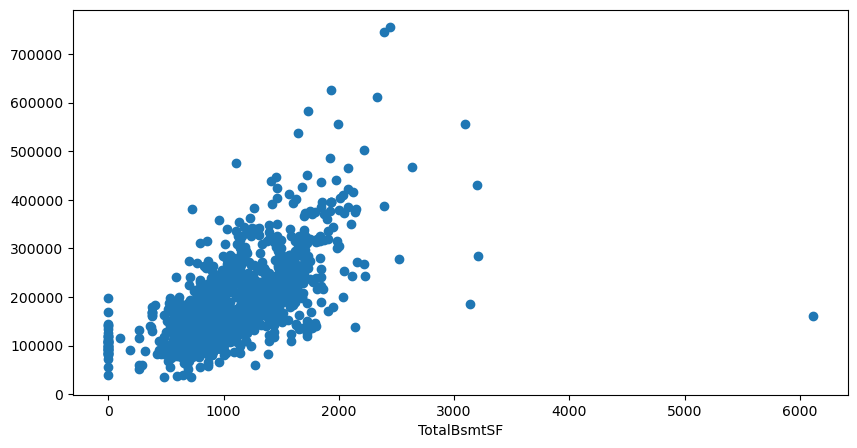

In [ ]:

for i in house_price.columns:
    if str(i)!= 'SalePrice':
        plt.figure(figsize=(10,5))
        plt.scatter(x = house_price[i], y = house_price.SalePrice)
        plt.xlabel(str(i))
plt.show()

In [ ]:
house_price = pd.concat([df_with_NA,df_without_NA,house_price], axis = 1)

In [ ]:
house_price.head(5)

### MLR using regularization

#### Linear Regresion

In [ ]:
scaler = MinMaxScaler()

In [ ]:
y = house_price['SalePrice']

In [ ]:
df_train, df_test = train_test_split(house_price, train_size = 0.7, test_size = 0.3, random_state = 100)

In [ ]:
y_train = df_train.pop('SalePrice')
X_train = df_train

y_test = df_test.pop('SalePrice')
X_test = df_test

In [ ]:
lm = LinearRegression()
lm.fit(X_train,y_train)

In [ ]:
print(lm.intercept_)

In [ ]:
print(lm.coef_)

In [ ]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric=[]
r2_train_lr = r2_score(y_train,y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test,y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)






### Ridge and Lasso Regression


### Ridge

In [ ]:
params = {'alpha':[0.0001,0.001,0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,
                  9.0, 10, 20, 50, 100, 500, 1000]}
ridge = Ridge()

folds = 5 
model_cv = GridSearchCV(estimator = ridge,
                       param_grid = params,
                       scoring = 'neg_mean_absolute_error',
                       cv = folds,
                       return_train_score = True,
                       verbose = 1)
model_cv.fit(X_train,y_train)

In [ ]:
print(model_cv.best_params_)

In [ ]:
ridge = Ridge(alpha = 50)
ridge.fit(X_train,y_train)
print(ridge.coef_)

In [ ]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train,y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test,y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

### Lasso

In [ ]:
lasso = Lasso()
model_cv = GridSearchCV(estimator = lasso,
                       param_grid = params,
                       scoring = 'neg_mean_absolute_error',
                       cv = folds,
                       return_train_score = True,
                       verbose = 1)
model_cv.fit(X_train,y_train)

In [ ]:
print(model_cv.best_params_)

In [ ]:
lasso = Lasso(alpha = 20)
lasso.fit(X_train,y_train)

In [ ]:
lasso.coef_

#### lasso summary statistics

In [ ]:

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train,y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test,y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

### Summary statistics from all methods

In [149]:
lr_table = {'Metric' : ['R2 Score(Train)', 'R2 Score(test)', 'RSS(Train)', 'RSS(test)','MSE(Train)','MSE(test)'],'Linear Regression': metric}
lr_metric = pd.DataFrame(lr_table, columns= ['Metric','Linear Regression'])
rg_metric = pd.Series(metric2, name = 'Ridge Regression')
lg_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric,rg_metric,lg_metric], axis = 1)
final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score(Train),9.484347e-01,8.717502e-01,9.374591e-01
1,R2 Score(test),-2.931258e+08,8.637399e-01,8.450176e-01
2,RSS(Train),3.290227e+11,8.183234e+11,3.990547e+11
3,RSS(test),8.262374e+20,3.840781e+11,4.368510e+11
4,MSE(Train),1.795147e+04,2.831064e+04,1.976985e+04
5,MSE(test),1.373458e+09,2.961234e+04,3.158127e+04


### Comparing coefficients after and before regularization

In [150]:
compare_co = pd.DataFrame(index = X_train.columns)
compare_co.rows = X_train.columns
compare_co['LinearRegression'] = lm.coef_
compare_co['Ridge'] = ridge.coef_
compare_co['Lasso'] = lasso.coef_
compare_co.head(20)

,LinearRegression,Ridge,Lasso
Alley_Grvl,-1.474272e+03,-439.986091,0.000000
Alley_Pave,-6.493782e+03,-644.162274,-3322.423546
MasVnrType_BrkCmn,4.456418e+02,-2431.570437,-3214.738367
MasVnrType_BrkFace,-3.266159e+03,-4104.997553,-4846.984383
MasVnrType_Stone,2.105109e+03,-2814.361789,-1840.807831
BsmtQual_Ex,-1.230521e+12,15042.065363,16957.367948
BsmtQual_Fa,-1.230521e+12,-352.916804,0.000000
BsmtQual_Gd,-1.230521e+12,-8666.023330,-10384.727040
BsmtQual_TA,-1.230521e+12,-4187.219671,-5313.701017
BsmtCond_Fa,7.052826e+11,-889.264543,-0.000000


### Ridge top 15 coefficients

In [151]:
coeff = ridge.coef_
abs_coeff = np.abs(coeff)

coefs = dict(zip(X_train.columns, abs_coeff))

sorted_coefs = {i:j for i,j in sorted(coefs.items(), key = lambda item : item[1], reverse = True)}

#top15 predictors
n=15
for predictor, coefficient in list(sorted_coefs.items())[:n]:
    print(f"{predictor} : coefficient = {coefficient}")

BsmtQual_Ex : coefficient = 15042.065362753025
Neighborhood_NoRidge : coefficient = 14157.827416792574
OverallQual : coefficient = 12589.584886786146
Neighborhood_NridgHt : coefficient = 12025.26366074184
BsmtExposure_Gd : coefficient = 10897.757524213916
Neighborhood_Edwards : coefficient = 10432.592678074383
KitchenQual_Gd : coefficient = 9808.26362757478
Condition1_Norm : coefficient = 9461.655474116305
GarageCars : coefficient = 9087.751299166966
BsmtQual_Gd : coefficient = 8666.02333047198
BsmtFullBath : coefficient = 8133.293456235018
Neighborhood_Crawfor : coefficient = 8031.912146086157
KitchenQual_TA : coefficient = 7866.519099643783
BsmtExposure_No : coefficient = 7417.384256289986
BsmtFinType1_GLQ : coefficient = 6477.434401609309


### Lasso top 15 coefficients

In [152]:
coeff = lasso.coef_
abs_coeff = np.abs(coeff)

coefs = dict(zip(X_train.columns, abs_coeff))

sorted_coefs = {i:j for i,j in sorted(coefs.items(), key = lambda item : item[1], reverse = True)}

#top10 predictors
n=15
for predictor, coefficient in list(sorted_coefs.items())[:n]:
    print(f"{predictor} : coefficient = {coefficient}")

RoofMatl_WdShngl : coefficient = 420594.0982278931
Condition2_PosN : coefficient = 367790.86072084226
RoofMatl_CompShg : coefficient = 356198.88774850685
RoofMatl_Membran : coefficient = 353160.62915995566
RoofMatl_WdShake : coefficient = 345343.1303639763
RoofMatl_Tar&Grv : coefficient = 337811.9701785754
RoofMatl_Roll : coefficient = 330060.42526537133
RoofMatl_Metal : coefficient = 323957.5036506996
Neighborhood_NoRidge : coefficient = 36308.854220479974
KitchenQual_Gd : coefficient = 27763.59280211099
KitchenQual_TA : coefficient = 25500.18613841509
Condition2_PosA : coefficient = 24626.583035405747
Neighborhood_StoneBr : coefficient = 23986.183822891504
Neighborhood_Crawfor : coefficient = 23879.05414939279
Heating_OthW : coefficient = 23492.412056356374


## By seeing the summary statistics, The ridge model seems more stable than the other two. So the top 15 predictors are:

- BsmtQual_Ex
- Neighborhood_NoRidge 
- OverallQual
- Neighborhood_NridgHt 
- BsmtExposure_Gd 
- Neighborhood_Edwards 
- KitchenQual_Gd
- Condition1_Norm
- GarageCars 
- BsmtQual_Gd
- BsmtFullBath
- Neighborhood_Crawfor 
- KitchenQual_TA 
- BsmtExposure_No
- BsmtFinType1_GLQ


### Working for Assignment Subjective questions

#### Question 1:

- Optimal value for alpha of Ridge regression is 50, we are doubling it.

In [153]:
ridge1 = Ridge(alpha = 100)
ridge1.fit(X_train,y_train)

coeff = ridge1.coef_
abs_coeff = np.abs(coeff)

coefs = dict(zip(X_train.columns, abs_coeff))

sorted_coefs = {i:j for i,j in sorted(coefs.items(), key = lambda item : item[1], reverse = True)}

#top 5 predictors
n = 5
for predictor, coefficient in list(sorted_coefs.items())[:n]:
    print(f"{predictor} : coefficient = {coefficient}")

OverallQual : coefficient = 12768.182533442152
BsmtQual_Ex : coefficient = 11529.895322623523
Neighborhood_NoRidge : coefficient = 8690.508650422118
Neighborhood_NridgHt : coefficient = 8351.692691837983
BsmtExposure_Gd : coefficient = 8099.191912732422


- Optimal value for Lasso regression alpha is 20, we are doubling it.

In [154]:
lasso1 = Lasso(alpha = 40)
lasso1.fit(X_train,y_train)
coeff = lasso1.coef_
abs_coeff = np.abs(coeff)

coefs = dict(zip(X_train.columns, abs_coeff))

sorted_coefs = {i:j for i,j in sorted(coefs.items(), key = lambda item : item[1], reverse = True)}

#top5 predictors
n = 5
for predictor, coefficient in list(sorted_coefs.items())[:n]:
    print(f"{predictor} : coefficient = {coefficient}")

Condition2_PosN : coefficient = 290103.6416488474
RoofMatl_WdShngl : coefficient = 121220.16860766623
RoofMatl_CompShg : coefficient = 56115.48227676683
Neighborhood_NoRidge : coefficient = 41786.95135806966
RoofMatl_WdShake : coefficient = 37331.55075556562


## Solving question 3:

#### Dropping the top 5 variables from Lasso model

In [155]:
X_train_lasso = X_train.drop(['RoofMatl_WdShngl','RoofMatl_CompShg','RoofMatl_Membran','Condition2_PosN','RoofMatl_WdShake'],axis =1)

#### Reduiling the Lasso regresion model after dropping the top 5 predictors.

In [156]:
lasso = Lasso()
model_cv = GridSearchCV(estimator = lasso,
                       param_grid = params,
                       scoring = 'neg_mean_absolute_error',
                       cv = folds,
                       return_train_score = True,
                       verbose = 1)
model_cv.fit(X_train_lasso,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [157]:
print(model_cv.best_params_)

{'alpha': 100}


In [158]:
lasso = Lasso(alpha = 100)
lasso.fit(X_train_lasso,y_train)

Lasso(alpha=100)

In [159]:
lasso.coef_

array([-0.00000000e+00, -0.00000000e+00, -1.45830468e+03, -2.83925300e+03,
       -4.65130306e+03,  3.10486207e+04,  0.00000000e+00, -2.58020319e+03,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        3.19783278e+03,  1.66702822e+03,  1.96391471e+04, -0.00000000e+00,
       -6.50277933e+03,  1.64432751e+03,  2.28146675e+03,  4.88528971e+03,
       -0.00000000e+00, -0.00000000e+00, -5.47523361e+03,  1.52333519e+03,
       -2.19513966e+03,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        2.91693489e+03, -4.86860088e+02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.03673492e+04, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  4.97469661e+02, -0.00000000e+00,
        8.36230183e+02, -0.00000000e+00, -2.10380897e+03, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -4.30221100e+03, -4.60435065e+03,
        0.00000000e+00, -1.04638207e+04,  0.00000000e+00, -0.00000000e+00,
       -4.98529680e+03,  

In [160]:
#lasso summary statistics
X_test_lasso = X_test.drop(['RoofMatl_WdShngl','RoofMatl_CompShg','RoofMatl_Membran','Condition2_PosN','RoofMatl_WdShake'],axis =1)
y_pred_train = lasso.predict(X_train_lasso)
y_pred_test = lasso.predict(X_test_lasso)

metric4 = []
r2_train_lr = r2_score(y_train,y_pred_train)
print(r2_train_lr)
metric4.append(r2_train_lr)

r2_test_lr = r2_score(y_test,y_pred_test)
print(r2_test_lr)
metric4.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric4.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric4.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric4.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric4.append(mse_test_lr**0.5)

0.8886122367393535
0.8647306646745334
710731767313.6426
381285370454.0518
696113386.2033718
870514544.4156435


In [161]:
#Lasso top 15 coefficients
coeff = lasso.coef_
abs_coeff = np.abs(coeff)

coefs = dict(zip(X_train.columns, abs_coeff))

sorted_coefs = {i:j for i,j in sorted(coefs.items(), key = lambda item : item[1], reverse = True)}

#top10 predictors
n=15
for predictor, coefficient in list(sorted_coefs.items())[:n]:
    print(f"{predictor} : coefficient = {coefficient}")

Neighborhood_NoRidge : coefficient = 47626.64997865523
BsmtQual_Ex : coefficient = 31048.620747449444
Neighborhood_NridgHt : coefficient = 30741.842576636456
Neighborhood_Somerst : coefficient = 23860.088942732855
Neighborhood_Crawfor : coefficient = 23279.605848286606
HeatingQC_Gd : coefficient = 22708.74469393743
HeatingQC_Po : coefficient = 22372.693242925558
Neighborhood_StoneBr : coefficient = 21761.170880551028
BsmtExposure_Gd : coefficient = 19639.147064176566
RoofMatl_Tar&Grv : coefficient = 17281.084562089083
Neighborhood_Edwards : coefficient = 16347.919700880353
LotShape_IR3 : coefficient = 14491.100500100822
LandContour_Lvl : coefficient = 14487.601221841778
HeatingQC_Fa : coefficient = 14320.049494434481
Condition1_Norm : coefficient = 12263.91180346461


### The top 5 predictors in the new lasso model are 
- Neighborhood_NoRidge
- BsmtQual_Ex
- Neighborhood_NridgHt
- Neighborhood_Somerst
- Neighborhood_Crawfor' 